# Image classification with blended images

First need to create and have a model, either pretrained or from scratch.
I am going to use the data and the model from tutorial 4 as a basis, to do the comparison

## Setup importing tensorflow and getting required images

In [1]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



This is to download and unzip along with showing the directories. (Changed ls to dir due to being on windows)

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!dir
!dir PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   143M      0  0:00:05  0:00:05 --:--:--  152M
kagglecatsanddogs_3367a.zip  PetImages	    sample_data
MSR-LA\ -\ 3467.docx	     readme[1].txt
Cat  Dog


## Filtering corrupted images

Following same method from tutorial 4 to filter out corrupted images

In [3]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)



Deleted 1590 images


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


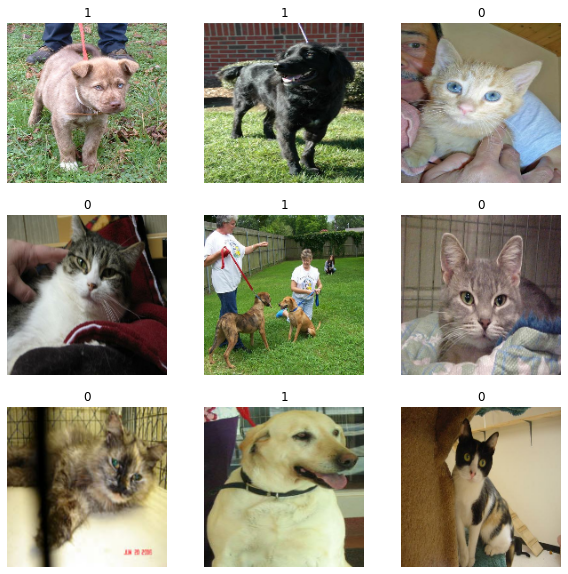

In [4]:
#generating the dataset from tutorial

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


#visualizing a few images from said dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")





Data augmentation to increase accuracy and reduce overfitting of the model

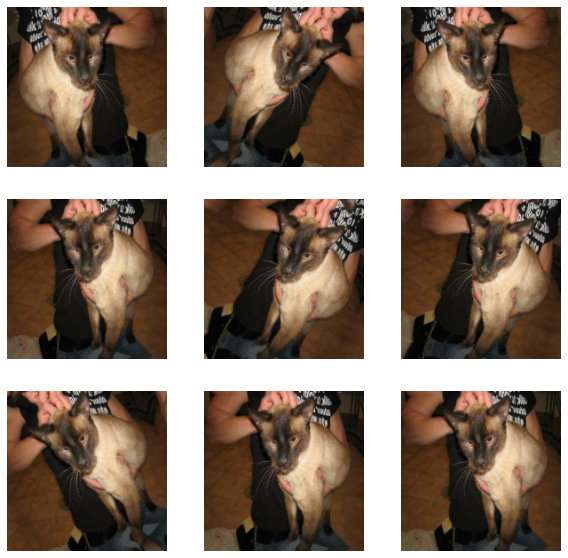

In [5]:


data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#Configure the dataset for performance

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [6]:
#model taken from tutorial 4

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

In [7]:
#training model from tutorial 4

epochs = 5 

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)



Epoch 1/5
586/586 [==============================] - 164s 255ms/step - loss: 0.6373 - accuracy: 0.6588 - val_loss: 0.5487 - val_accuracy: 0.7245
Epoch 2/5
586/586 [==============================] - 151s 257ms/step - loss: 0.4687 - accuracy: 0.7778 - val_loss: 0.4037 - val_accuracy: 0.8176
Epoch 3/5
586/586 [==============================] - 151s 257ms/step - loss: 0.3857 - accuracy: 0.8260 - val_loss: 0.5585 - val_accuracy: 0.7334
Epoch 4/5
586/586 [==============================] - 154s 262ms/step - loss: 0.3122 - accuracy: 0.8636 - val_loss: 0.3081 - val_accuracy: 0.8667
Epoch 5/5
586/586 [==============================] - 152s 258ms/step - loss: 0.2569 - accuracy: 0.8938 - val_loss: 0.3069 - val_accuracy: 0.8710


Once, the model is trained, we can use an image from our dataset to test if the accuracy for the model has been reached.

This image is 91.80 percent cat and 8.20 percent dog.


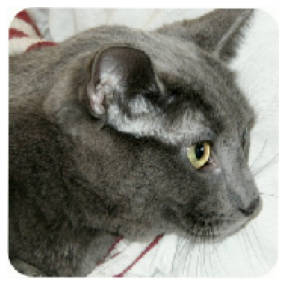

In [8]:
#from tutorial 4 to check for accuracy

img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)

# Plot image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")

# Preprocess image
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions on images
predictions = model.predict(img_array)
score = predictions[0]

print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)



# Generating the new dataset to be tested through image pairing and image blending

Copying cat files and renaming them into the new blending image folder

In [10]:
!mkdir BlendingImages

In [11]:
import shutil

fnames = ['{}.jpg'.format(i) for i in range(10)]
fnewnamecats = ['cat{}.jpg'.format(i) for i in range(10)]
for x in range(10):
    src = os.path.join('PetImages/Cat', fnames[x])
    dst = os.path.join('PetImages/BlendingImages', fnewnamecats[x])
    shutil.copyfile(src, dst)

Repeating the same process with dog files

In [12]:
fnames = ['{}.jpg'.format(i) for i in range(21,31)]
fnewnamedogs = ['dog{}.jpg'.format(i) for i in range(10)]
for x in range(10):
    src = os.path.join('PetImages/Dog', fnames[x])
    dst = os.path.join('PetImages/BlendingImages', fnewnamedogs[x])
    shutil.copyfile(src, dst)

# Start to blend the cat images and the dog images

Blending will be paired using the numbers at the end, done by renaming the image names.
Blending ratios will be 25%, 33%, 50%, 66% and 75%

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

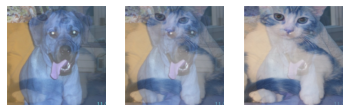

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os

Blended_25 = []
Blended_50 = []
Blended_75 = []

for x in range(10):

  image1 = cv2.imread('PetImages/BlendingImages/' + fnewnamecats[x])
  image2 = cv2.imread('PetImages/BlendingImages/' + fnewnamedogs[x])

  #resize the image so that they can fit togheter
  resized1 = cv2.resize(image1, (180, 180), interpolation = cv2.INTER_AREA)
  resized2 = cv2.resize(image2, (180, 180), interpolation = cv2.INTER_AREA)

  blendedimage_25 = cv2.addWeighted(resized1,0.25,resized2,0.75,0)
  blendedimage_50 = cv2.addWeighted(resized1,0.5,resized2,0.5,0)
  blendedimage_75 = cv2.addWeighted(resized1,0.75,resized2,0.25,0)
  Blended_25.append(blendedimage_25)
  Blended_50.append(blendedimage_50)
  Blended_75.append(blendedimage_75)
  
  plt.subplot(131), plt.imshow(blendedimage_25), plt.axis('off') 
  plt.subplot(132), plt.imshow(blendedimage_50), plt.axis('off') 
  plt.subplot(133), plt.imshow(blendedimage_75), plt.axis('off') 



Now that the images have been blended, they can be feed to the model as inputs to see what the predictions are depending on the ratio of the images

(-0.5, 179.5, 179.5, -0.5)

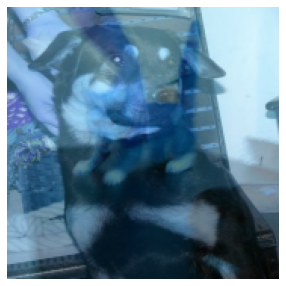

In [14]:
plt.figure(figsize=(5, 5))
plt.imshow(Blended_50[0])
plt.axis("off")

0 This image is 53.23 percent cat and 46.77 percent dog for a 25 cat/75 dog blend.
0 This image is 52.09 percent cat and 47.91 percent dog for a 50/50 cat dog blend.
0 This image is 38.36 percent cat and 61.64 percent dog for a 75/25 cat dog blend.
1 This image is 53.23 percent cat and 46.77 percent dog for a 25 cat/75 dog blend.
1 This image is 52.09 percent cat and 47.91 percent dog for a 50/50 cat dog blend.
1 This image is 38.36 percent cat and 61.64 percent dog for a 75/25 cat dog blend.
2 This image is 53.23 percent cat and 46.77 percent dog for a 25 cat/75 dog blend.
2 This image is 52.09 percent cat and 47.91 percent dog for a 50/50 cat dog blend.
2 This image is 38.36 percent cat and 61.64 percent dog for a 75/25 cat dog blend.
3 This image is 53.23 percent cat and 46.77 percent dog for a 25 cat/75 dog blend.
3 This image is 52.09 percent cat and 47.91 percent dog for a 50/50 cat dog blend.
3 This image is 38.36 percent cat and 61.64 percent dog for a 75/25 cat dog blend.
4 Th

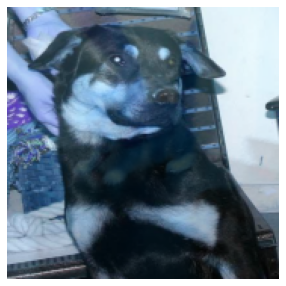

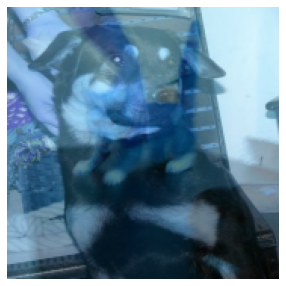

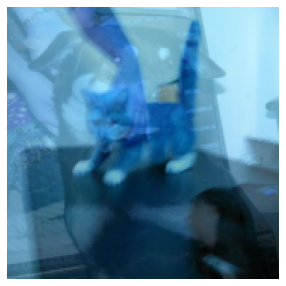

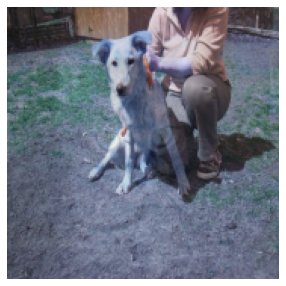

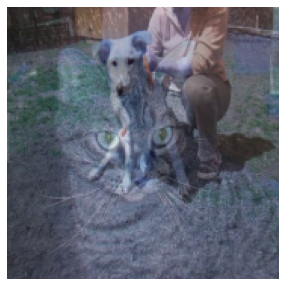

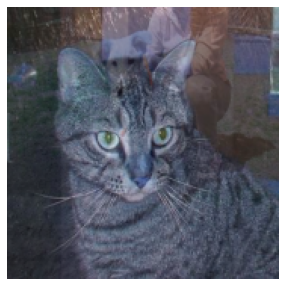

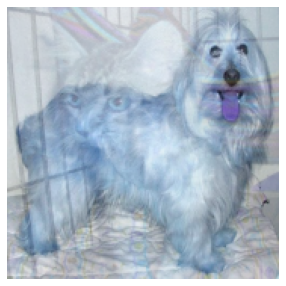

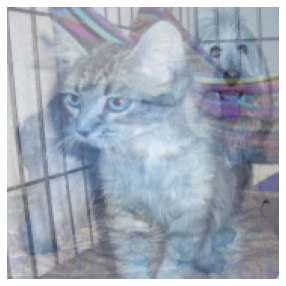

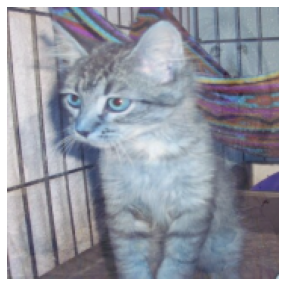

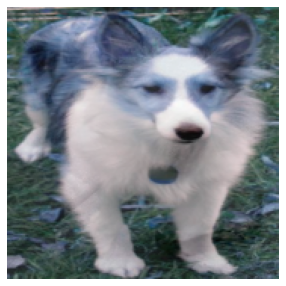

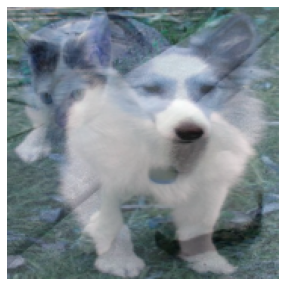

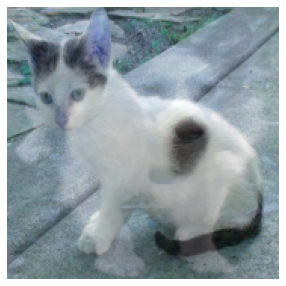

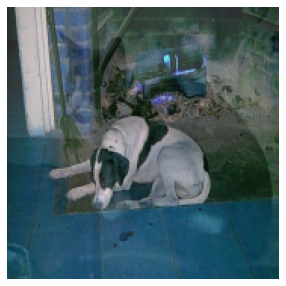

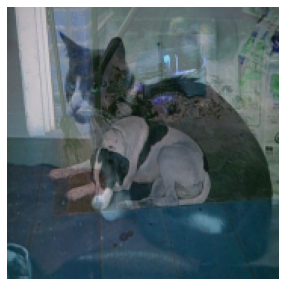

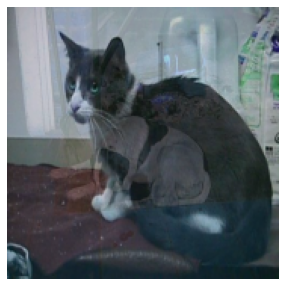

In [25]:

#from tutorial 4 to check for accuracy

for x in range(5):
  # Plot image
  plt.figure(figsize=(5, 5))
  plt.imshow(Blended_25[x])
  plt.axis("off")

  # Preprocess image
  img_array = keras.preprocessing.image.img_to_array(Blended_25[0])
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  # Make predictions on images
  predictions = model.predict(img_array)
  score = predictions[0]

  print(
      str(x) +
      " This image is %.2f percent cat and %.2f percent dog for a 25 cat/75 dog blend."
      % (100 * (1 - score), 100 * score)
  )

  # Plot image
  plt.figure(figsize=(5, 5))
  plt.imshow(Blended_50[x])
  plt.axis("off")

  # Preprocess image
  img_array = keras.preprocessing.image.img_to_array(Blended_50[0])
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  # Make predictions on images
  predictions = model.predict(img_array)
  score = predictions[0]

  print(
      str(x) +
      " This image is %.2f percent cat and %.2f percent dog for a 50/50 cat dog blend."
      % (100 * (1 - score), 100 * score)
  )

    # Plot image
  plt.figure(figsize=(5, 5))
  plt.imshow(Blended_75[x])
  plt.axis("off")

  # Preprocess image
  img_array = keras.preprocessing.image.img_to_array(Blended_75[0])
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  # Make predictions on images
  predictions = model.predict(img_array)
  score = predictions[0]

  print(
      str(x) +
      " This image is %.2f percent cat and %.2f percent dog for a 75/25 cat dog blend."
      % (100 * (1 - score), 100 * score)
  )